Hamilton,W.L. *Graph Representation Learning*. 2020

# 이웃 중복 감지 (Neighborhood Overlap Detection)

[전 포스트](https://jo-cho.github.io/FinBlog/posts/machine_learning/GRL_02_1.html)에서 소개한 방법은 분류 작업에 유용한 피쳐들이기는 하지만, 노드 간의 관계(*relationships*)를 정량화하지는 못한다. 따라서 관계예측(relation prediction) 등에서는 유용하지 못하다.

<img src="img/fig2_3.png" width='600'>

> Figure 2.3 in Hamilton,*Graph Representation Learning*. 2020: Full graph와 학습을 위한 subsampled graph

이 포스트에서는 두 노드 간의 이웃 중복(overlap)에 대한 다양한 통계 측정을 고려하여 두 노드 간의 관계 정도를 정량화한다.
- 예를 들어, 가장 간단한 이웃 중복도 측정은 두 노드가 공유하는 이웃의 수를 계산하는 것이다.

$$S[u,v] = | \mathcal{N}(u) \cap \mathcal{N}(v) |$$

- $S[u,v]$는 노드 $u$와 $v$ 사이 관계를 정량화한 값을 나타내며, $S \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$는 모든 쌍별(pairwise) 노드 통계량을 요약하는 유사도 행렬(*similarity matrix*)이다.

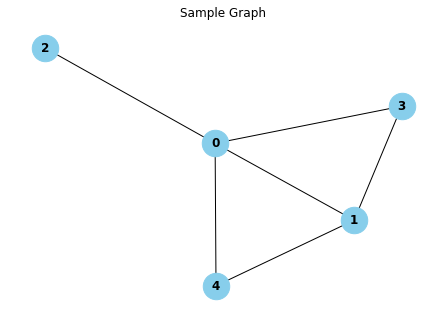

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Sample graph 생성
n = 5  # 노드 개수
m = 2    # 새로운 노드에 연결되는 엣지 수
G = nx.barabasi_albert_graph(n, m)
# 시각화
pos = nx.spring_layout(G)  # 그래프 레이아웃 정의
# 노드 및 엣지 그리기
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=12, font_weight="bold")
plt.title("Sample Graph")
plt.show()

관계 예측(relation prediction)에 사용

- 이웃 중복도 $S[u,v]$가 주어졌을 때, 엣지 $(u,v)$의 가능도(likelihood)가 $S[u,v]$에 단순 비례한다고 가정하고는 한다.
$$P(A[u,v]=1) \propto S[u,v]$$

- 따라서, 이웃 중복도는 관계 예측을 할 때 언제 엣지가 존재하는 것으로 예측할지 결정하기 위한 임계값을 설정하는 역할을 한다. 

- 관계 예측을 설정할 때에는 일반적으로 실제 엣지의 하위 집합 $\mathcal{E}_{train} \subset \mathcal{E}$만 알고 있다고 가정하고, 훈련 엣지에서 계산된 노드-노드 유사성 측정이 테스트 엣지의 존재에 대한 정확한 예측으로 이어지는 것이 목표이다.

## Local Overlap Measures

로컬(local) 중복도는 두 노드가 공유하는 공통 이웃의 수의 함수이다.

- 예를 들어, Sorensen index는 노드-노드 이웃 중복의 행렬은 공통 이웃 수를 노드 degree의 합으로 정규화한다(큰 degree의 노드에 대한 예측 bias 방지).
$$S_{\text{Sorenson}}[u,v] = \frac{2|\mathcal{N}(u) \cap \mathcal{N}(u)|}{d_u + d_v}$$

- 비슷한 방법으로 Salton index, Jaccard overlap가 있다.
$$S_{\text{Salton}}[u,v] = \frac{2|\mathcal{N}(u) \cap \mathcal{N}(u)|}{\sqrt{d_ud_v}}$$
$$S_{\text{Jaccard}}[u,v] = \frac{|\mathcal{N}(u) \cap \mathcal{N}(u)|}{|\mathcal{N}(u) \cup \mathcal{N}(u)|}$$

또한, 공통 이웃 수가 아닌 공통 이웃의 중요도를 고려하는 방법도 있다. degree가 낮은 공통 이웃(더 informative할 것이라고 가정)에 가중을 준다.

- Resource allocation(RA) index는 공통 이웃의 역 차수(inverse degree)를 카운트한다.
$$ S_{RA}[v_1,v_2] = \sum_{u \in \mathcal{N}(v_1) \cap \mathcal{N}(v_2)} \frac{1}{d_u} $$

- Adamic-Adar(AA) index는 공통 이웃의 역 로그 차수를 카운트한다.
$$ S_{AA}[v_1,v_2] = \sum_{u \in \mathcal{N}(v_1) \cap \mathcal{N}(v_2)} \frac{1}{\log(d_u)} $$

In [2]:
# 두 노드 간의 Jaccard 유사도 계산
def jaccard_similarity(G, node1, node2):
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    intersection = len(neighbors1.intersection(neighbors2))
    union = len(neighbors1.union(neighbors2))
    if union == 0:
        return 0
    return intersection / union

# 유사도 행렬 생성
nodes = list(G.nodes())
num_nodes = len(nodes)
similarity_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        similarity_matrix[i, j] = jaccard_similarity(G, nodes[i], nodes[j])

print("Jaccard 유사도 행렬:")
print(similarity_matrix)

Jaccard 유사도 행렬:
[[1.         0.4        0.         0.2        0.2       ]
 [0.4        1.         0.33333333 0.25       0.25      ]
 [0.         0.33333333 1.         0.5        0.5       ]
 [0.2        0.25       0.5        1.         1.        ]
 [0.2        0.25       0.5        1.         1.        ]]


In [3]:
def adamic_adar_similarity(G, node1, node2):
    common_neighbors = list(nx.common_neighbors(G, node1, node2))
    similarity = sum(1 / (len(list(G.neighbors(neighbor)))) for neighbor in common_neighbors if len(list(G.neighbors(neighbor))) > 1)
    return similarity
    
def adamic_adar_similarity_matrix(G):
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                similarity_matrix[i, j] = 0  # 같은 노드일 경우 유사도는 0
            else:
                similarity_matrix[i, j] = adamic_adar_similarity(G, nodes[i], nodes[j])
    return similarity_matrix

# Adamic-Adar 유사도 행렬 계산
similarity_matrix = adamic_adar_similarity_matrix(G)
print("Adamic-Adar 유사도 행렬:")
print(similarity_matrix)

Adamic-Adar 유사도 행렬:
[[0.         1.         0.         0.33333333 0.33333333]
 [1.         0.         0.25       0.25       0.25      ]
 [0.         0.25       0.         0.25       0.25      ]
 [0.33333333 0.25       0.25       0.         0.58333333]
 [0.33333333 0.25       0.25       0.58333333 0.        ]]


## Global Overlap Measures

로컬 중복도는 이름처럼 국소적인 노드 이웃만을 고려하기 때문에, 그래프의 같은 커뮤니티 멤버이더라도 국소적 중복이 없을 때 이를 감지하지 못할 수 있다. 글로벌 중복은 이러한 것을 고려한다.

### Katz Index

가장 기본적인 글로벌(global) 중복 통계량으로 노드 쌍 사이 모든 길이(lengths)의 경로의 수를 카운트한다.

$$S_{\text{Katz}}[u,v] = \sum^{\infty}_{i=1}\beta^iA^i[u,v] $$

- $\beta \in \mathbb{R}^+ (<1)$는 사용자 설정값으로 길이간 긴 경로에 더 낮은 가중치를 부여한다.

- Katz index의 해답은 다음과 같이 주어질 수 있다:

$$S_{\text{Katz}} = (I-\beta A)^{-1}-I$$

  - $S_{\text{Katz}} \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$는 노드-노드 유사도 값의 full 행렬이다.

### Leicht, Holme, and Newman (LHN) Similarity

 Katz Index는 노드 degree에 강하게 편향되어 있다. 이에 Leicht et al.(2006)은 실제 관찰된 경로 수와 두 노드 간 *기대 경로 수*의 비율을 제시했다. 즉, 두 노드 간 경로의 수를 랜덤모형에서의 경로 수 기대값으로 정규화하는 것이다.
 
 $$\frac{A^i}{\mathbb{E}[A^i]}$$
 
${\mathbb{E}[A^i]}$를 계산하기 위해 *configuration model*을 이용하여 analytical하게 구한다:
$$\mathbb{E}[A[u,v]] = \frac{d_u d_v}{2m}$$
- $m=|\mathcal{E}|$는 그래프의 엣지 전체 수를 의미한다.
- 위 식은 랜덤 configuration model에서 엣지의 가능도(likelihood)는 단순히 두 노드 degree의 곱임을 뜻한다.
- 또한 $d_u$개 엣지가 $u$를 출발하여 $\frac{d_v}{2m}$의 확률로 $v$에 도착한다고 볼 수 있다.

길이 2의 경로의 경우, 
$$ \mathbb{E}[A^2[v_1,v_2]] = \frac{d_{v_1} d_{v_2}}{(2m)^{2}} \sum_{u \in \mathcal{V}} (d_u-1) d_u $$
와 같으며, 길이가 3이상일 경우는 처리하기 어려워진다. 단, 근사값으로,
$$ \mathbb{E}[A^i[u,v]] = \frac{d_u d_v \lambda^{i-1}}{2m} $$로 나타낼 수 있다.

해답을 구하기 위해, 행렬을 표현하면,

$$S_{LNH}[u,v] = I[u,v]+\frac{2m}{d_u d_v} \sum^{\infty}_{i=0}\beta \lambda_1^{1-i}A^i [u,v]$$
$$S_{LNH}[u,v] = 2\alpha m \lambda_1 D^{-1}(I-\frac{\beta}{\lambda_1}A)^{-1}D^{-1}$$

 - $D$는 대각에 노드 degree가 있는 행렬을 뜻한다.
 

In [5]:
def lhn_similarity(G, node1, node2):
    common_neighbors = list(nx.common_neighbors(G, node1, node2))
    if len(common_neighbors) == 0:
        return 0.0
    else:
        sum_inverse_degree = sum(1 / G.degree(neighbor) for neighbor in common_neighbors)
        return sum_inverse_degree / len(common_neighbors)

def lhn_similarity_matrix(G):
    num_nodes = len(G.nodes())
    similarity_matrix = np.zeros((num_nodes, num_nodes))
    for i, node1 in enumerate(G.nodes()):
        for j, node2 in enumerate(G.nodes()):
            if i == j:
                similarity_matrix[i, j] = 0.0  # 같은 노드의 유사도는 0
            else:
                similarity_matrix[i, j] = lhn_similarity(G, node1, node2)
    return similarity_matrix

# LHN 유사도 행렬 계산
lhn_matrix = lhn_similarity_matrix(G)
print("LHN 유사도 행렬:")
print(lhn_matrix)

LHN 유사도 행렬:
[[0.         0.5        0.         0.33333333 0.33333333]
 [0.5        0.         0.25       0.25       0.25      ]
 [0.         0.25       0.         0.25       0.25      ]
 [0.33333333 0.25       0.25       0.         0.29166667]
 [0.33333333 0.25       0.25       0.29166667 0.        ]]


### Random Walk Methods


그래프의 정확한 경로의 수를 세는 대신 랜덤워크를 고려하여 유사도를 측정할 수 있다.

'Personalized PageRank' 알고리즘(Leskovec et al., 2020)을 사용하면 확률(stochastic) 행렬 $P=AD^{-1}$가 있을 때, 랜덤워크가 노드 $u$에서 $v$로 가는 확률 $\mathbf{q}_u[v]$를 다음과 같이 구한다.

$$\mathbf{q}_u = cP\mathbf{q}_u+(1-c)\mathbf{e}_u$$
$$\mathbf{q}_u = (1-c)(I-cP)^{-1}\mathbf{e}_u$$


- $\mathbf{e}_u$는 노드 $u$에 대한 one-hot indicator 벡터
- $c$는 랜덤워크가 노드 $u$에서 다시 시작할 확률을 결정

노드-노드 랜덤워크 유사도 측정:

$$S_{RW}[u,v]=\mathbf{q}_u[v]+\mathbf{q}_v[u]$$

In [9]:
# Personalized PageRank 계산
def personalized_pagerank_similarity_matrix(G, alpha=0.85):
    # Personalized PageRank 계산
    pr_matrix = nx.pagerank(G, alpha=alpha)

    # 유사도 행렬 초기화
    num_nodes = len(G.nodes())
    similarity_matrix = np.zeros((num_nodes, num_nodes))

    # 각 노드 쌍 간의 Personalized PageRank 유사도 계산
    for i, node1 in enumerate(G.nodes()):
        for j, node2 in enumerate(G.nodes()):
            similarity_matrix[i, j] = abs(pr_matrix[node1] - pr_matrix[node2])
    return similarity_matrix

# Personalized PageRank 유사도 행렬 계산
ppr_similarity_matrix = personalized_pagerank_similarity_matrix(G)
print("Personalized PageRank 유사도 행렬:")
print(ppr_similarity_matrix)

Personalized PageRank 유사도 행렬:
[[0.         0.08351986 0.22581248 0.15743786 0.15743786]
 [0.08351986 0.         0.14229262 0.07391799 0.07391799]
 [0.22581248 0.14229262 0.         0.06837463 0.06837463]
 [0.15743786 0.07391799 0.06837463 0.         0.        ]
 [0.15743786 0.07391799 0.06837463 0.         0.        ]]


# 참고자료

[1] Hamilton, W. L. (2020). *Graph Representation Learning.* Morgan & Claypool Publishers.